<h2>Lab 7 - Event Selection Iotimization</h2>

Max Wang<br>
Phys 434

In [25]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import stats
import pickle
import pandas as pd
import h5py
plt.rcParams["figure.figsize"] = (12, 10)

In [3]:
# open the file of interest, and use pickle loading
higgs_data = pickle.load(open ("datafile/higgs_100000_pt_250_500.pkl",'rb'))
qcd_data = pickle.load(open ("datafile/qcd_100000_pt_250_500.pkl",'rb'))

In [4]:
higgs_data.keys()

Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')

<h3>Problem 1</h3>

Make a stacked histogram plot for the mass variable and evaluate expected significance without<br>
any event selection.

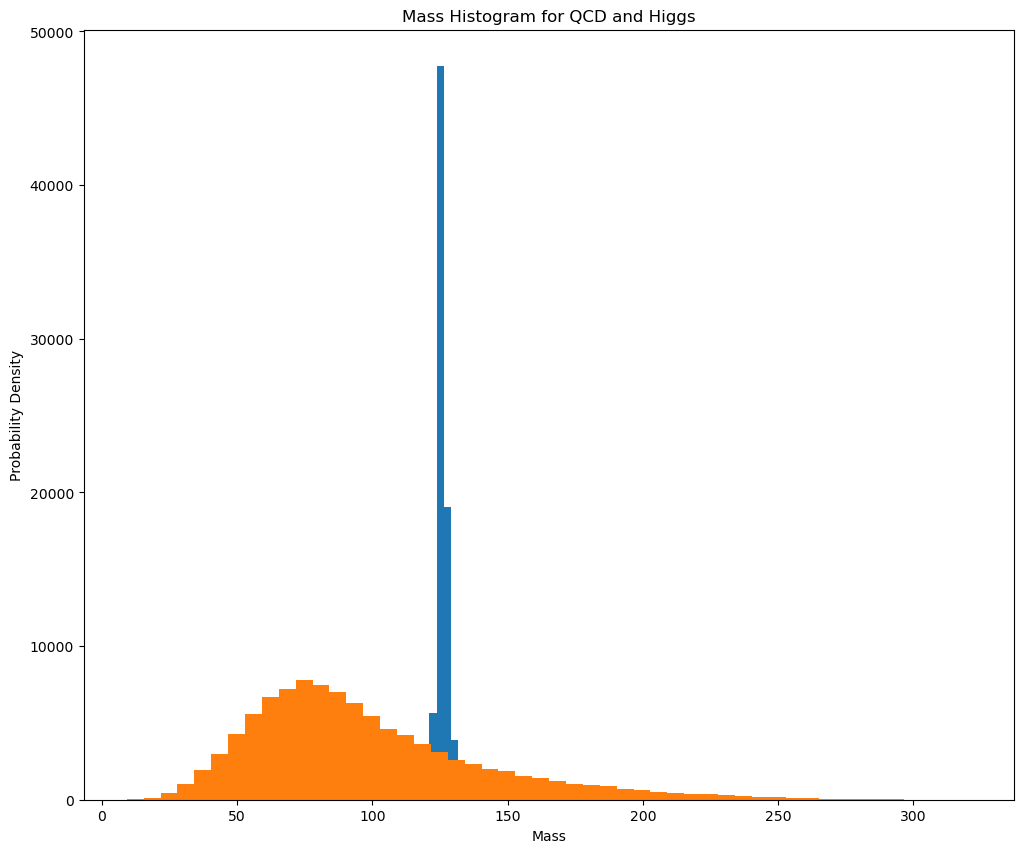

In [5]:
plt.xlabel("Mass")
plt.ylabel('Probability Density')
plt.title("Mass Histogram for QCD and Higgs")
plt.hist(higgs_data['mass'], 50)
plt.hist(qcd_data['mass'], 50)
plt.show()

The stacked histogram shows the distribution of the QCD data and Higgs data. On the distribution, we found <br>
that Higgs have a mass of about 130 GeV with a narrow standard deviation compared to the QCD background. Higgs <br>
boson is more massive than most of the particles in the background, which means we can use mass to distinguish  <br>
between Higgs and qcd.

In [6]:
higgs_num = 100
qcd_num = 20000
total_num = higgs_num + qcd_num
test = higgs_num/np.sqrt(qcd_num)
sig = stats.norm.ppf(stats.poisson.sf(qcd_num, total_num))

In [7]:
sig

0.7012225600355231

In [8]:
test

0.7071067811865475

As compared above, the exact signifiance is very close to the approximation of <br>
$\frac{N_{Higgs}}{\sqrt(N_{QCD})}$

<h3>Problem 2</h3>

Identify mass cuts to optimize the expected significance. Try different mass cuts systematically.

In [9]:
higgs_temp = higgs_data['mass'].values
higgs_store = higgs_temp[0:len(higgs_temp)]
qcd_temp = qcd_data['mass'].values
qcd_store = qcd_temp[0:len(qcd_temp)]

This function cuts the Higgs and qcd data with a given lower and upper bound, and it <br>
returns the nurmalized number of events for these data, and also the indices of the <br>
events that stays with the data. One note on the normalization of this function is that <br>
they are multiplied by 2 because currently the data counts are ranged from 50 to 10000, <br>
and it should be normalized to 100 to 20000.

In [10]:
def makeCut(lower, upper):
    store_higgs_indices = []
    store_qcd_indices = []
    
    for x in range(0, len(higgs_store)):
        if higgs_store[x] >= lower and higgs_store[x] <= upper:
            store_higgs_indices.append(x)
    for y in range(0, len(qcd_store)):
        if qcd_store[y] >= lower and qcd_store[y] <= upper:
            store_qcd_indices.append(y)
            
    total_events = len(higgs_data['mass']) + len(qcd_data['mass'])
    normalized_higgs = 2 * 100 * (len(store_higgs_indices) / total_events)
    normalized_qcd = 2 * 20000 * (len(store_qcd_indices) / total_events)
    
    return [normalized_higgs, normalized_qcd, store_higgs_indices, store_qcd_indices]

Since the average for the Higgs data is around 130, the range will initially be set <br>
to from 0 to 140 to find the optimal minimum for the mass cut.

In [11]:
max_sig = 0
max_lower = 0
for i in range(0, 135):
    x = makeCut(i, 135)
    higgs_count = x[0]
    qcd_count = x[1]
    sig = stats.norm.ppf(stats.poisson.cdf(higgs_count + qcd_count, qcd_count))
    if sig > max_sig:
        max_sig = sig
        max_lower = i

In [12]:
max_lower

124

In [13]:
max_sig

2.2525175674286517

The lower blound for the mass cut will be 124.

In [14]:
max_sig = 0
max_upper = 130
for i in range(0, 130 - max_lower):
    x = makeCut(max_lower, 130 - i)
    higgs_count = x[0]
    qcd_count = x[1]
    sig = stats.norm.ppf(stats.poisson.cdf(higgs_count + qcd_count, qcd_count))
    if sig > max_sig:
        max_sig = sig
        max_upper = 140 - i

In [15]:
max_upper

138

In [16]:
max_sig

3.0337389952368543

The upperbound is calculated to be 138, so the total two bounds ranges from 124 to 138,<br>
with the significance of 3.03 $\sigma$. The optimal mass cut is then stored in two arrays,<br>
with one being higgs and the other being qcd data.

In [17]:
temp = makeCut(124, 138)
mass_cut_higgs_indices = temp[2]
mass_cut_qcd_indices = temp[3]

<h3>Problem 3</h3>

The sets of stacked histogram plots are plotted for the rest of the features, with set A having<br>
no event selection and set B with the mass cut included with the range being from 124 to 138.

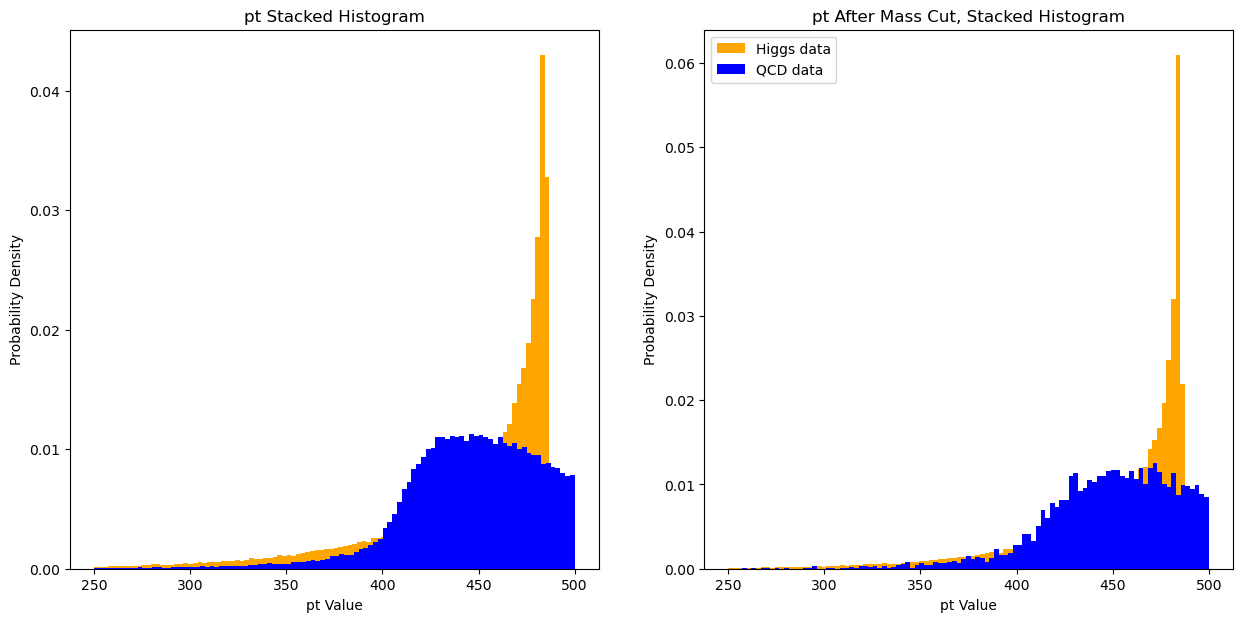

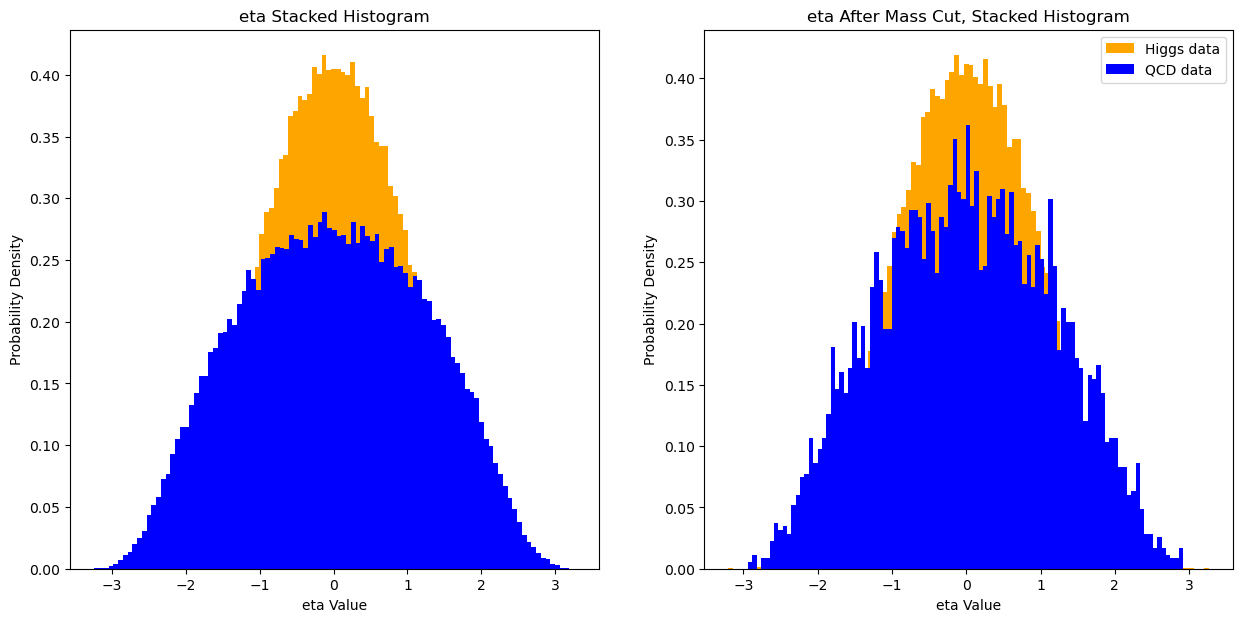

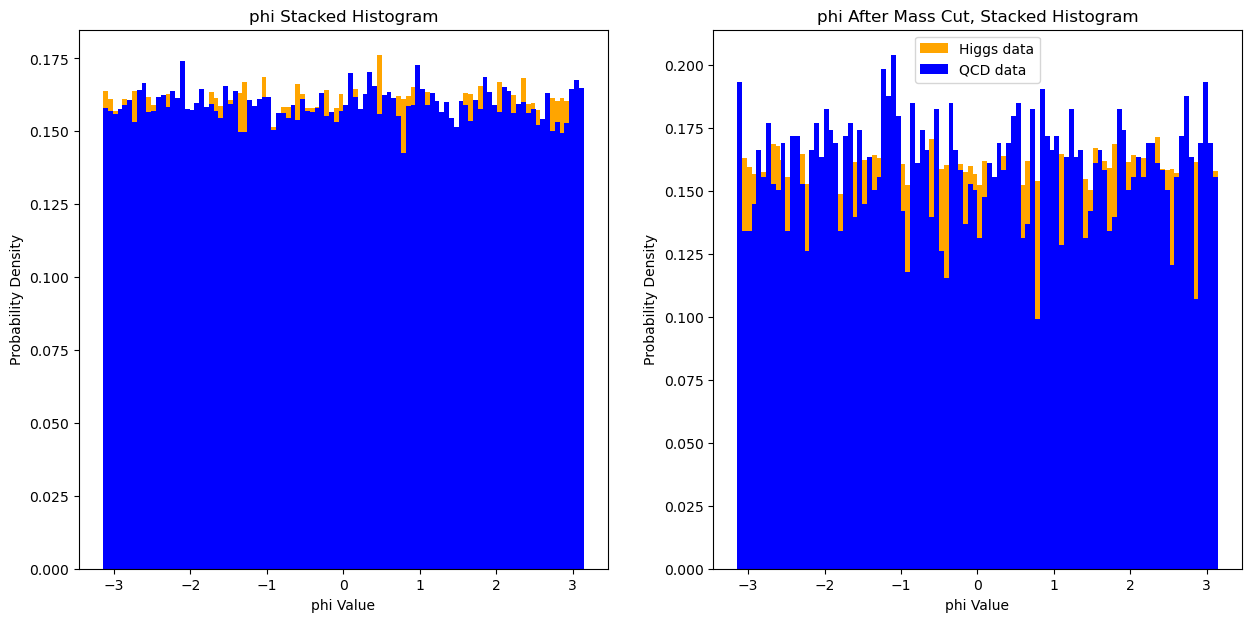

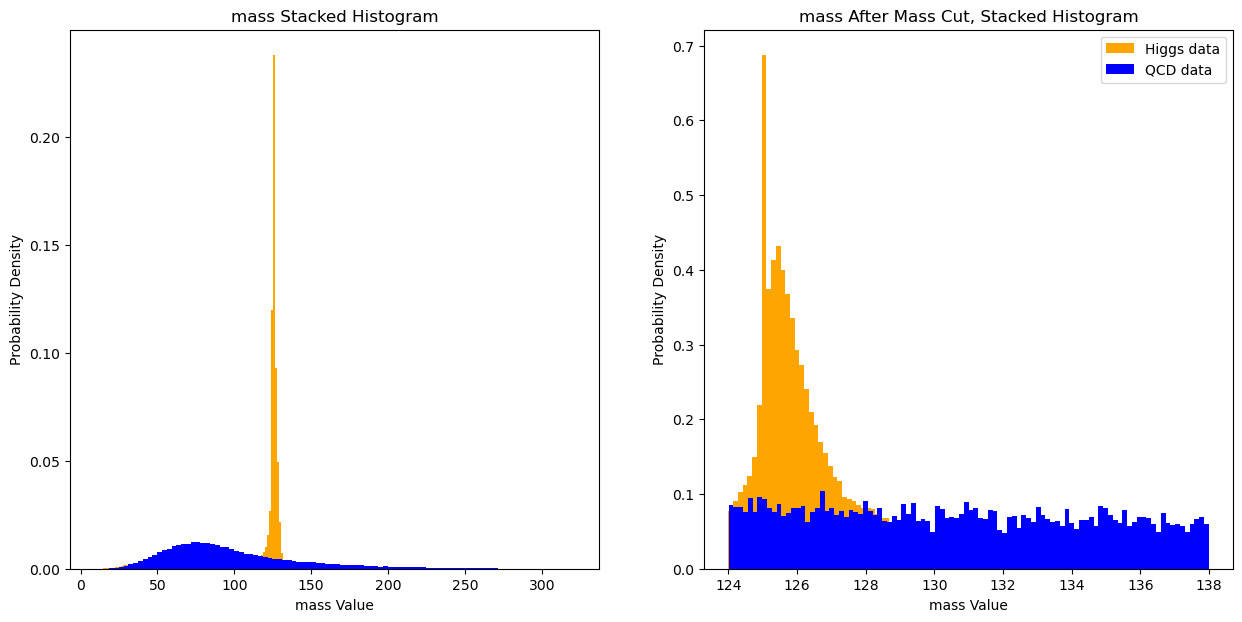

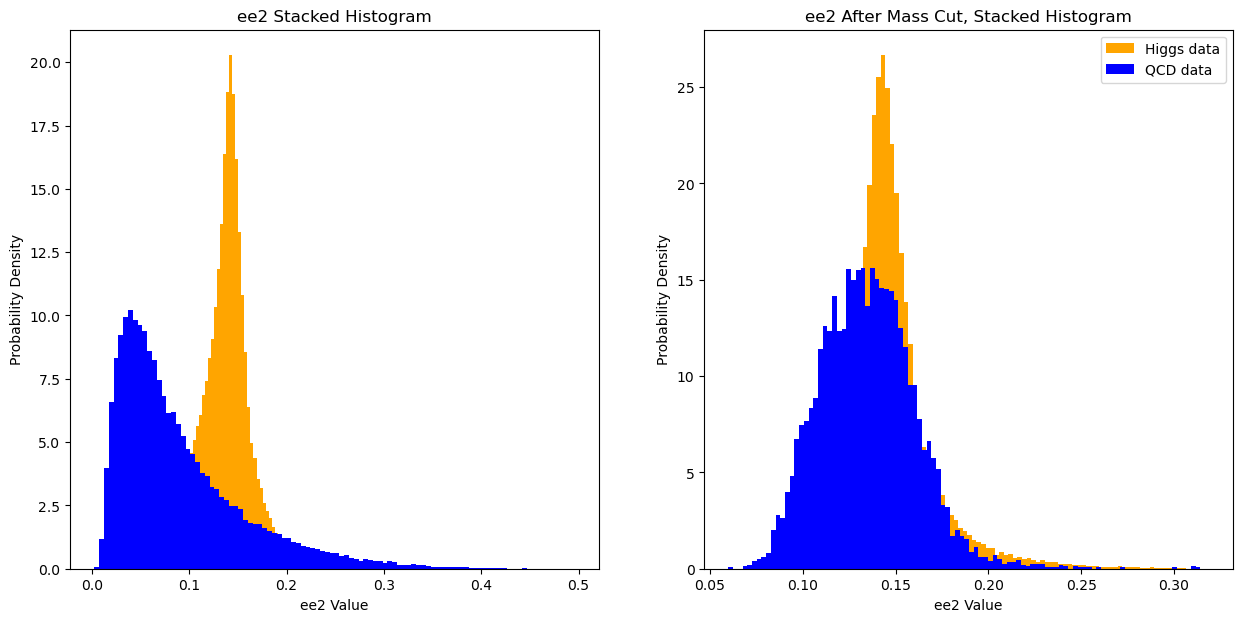

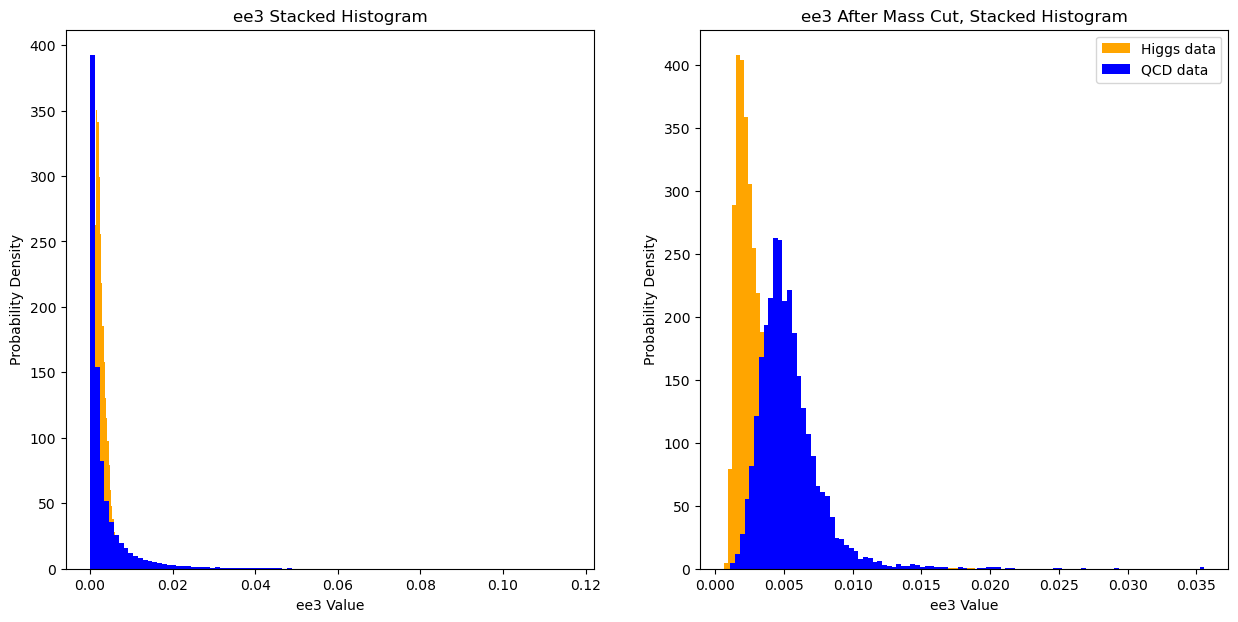

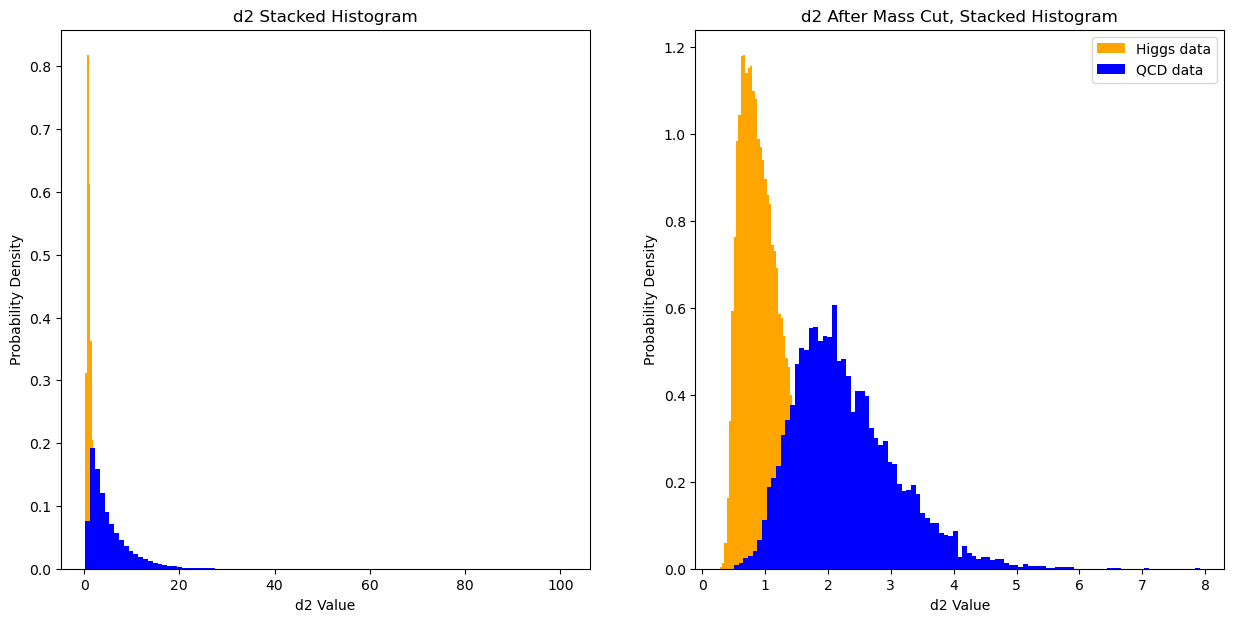

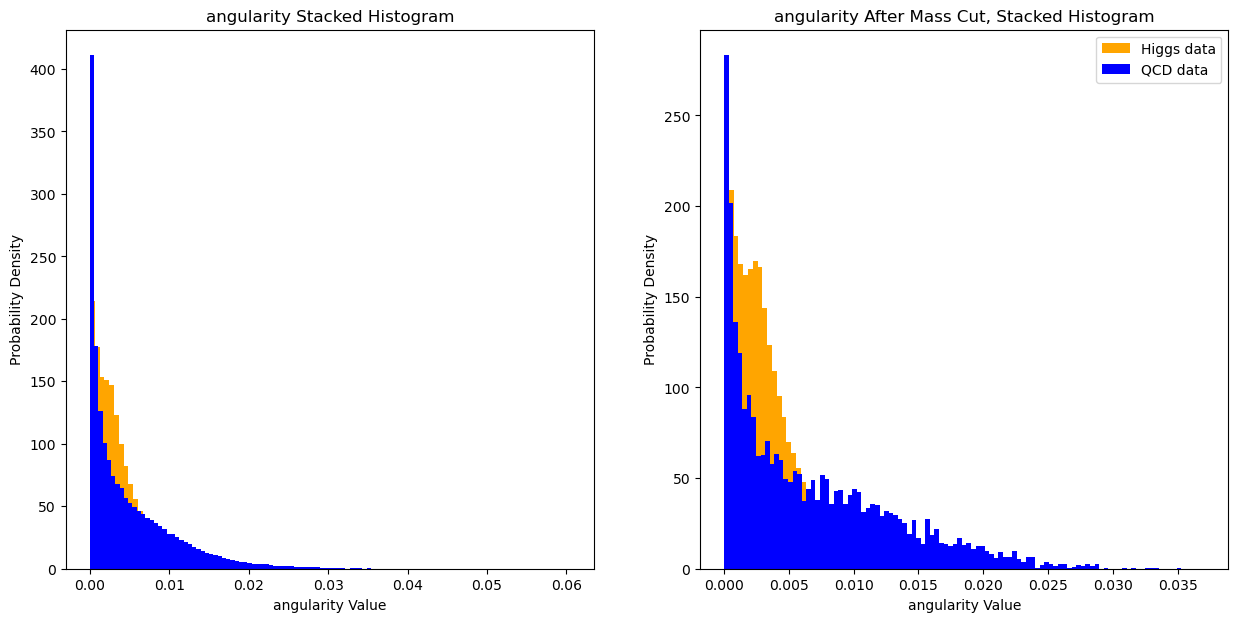

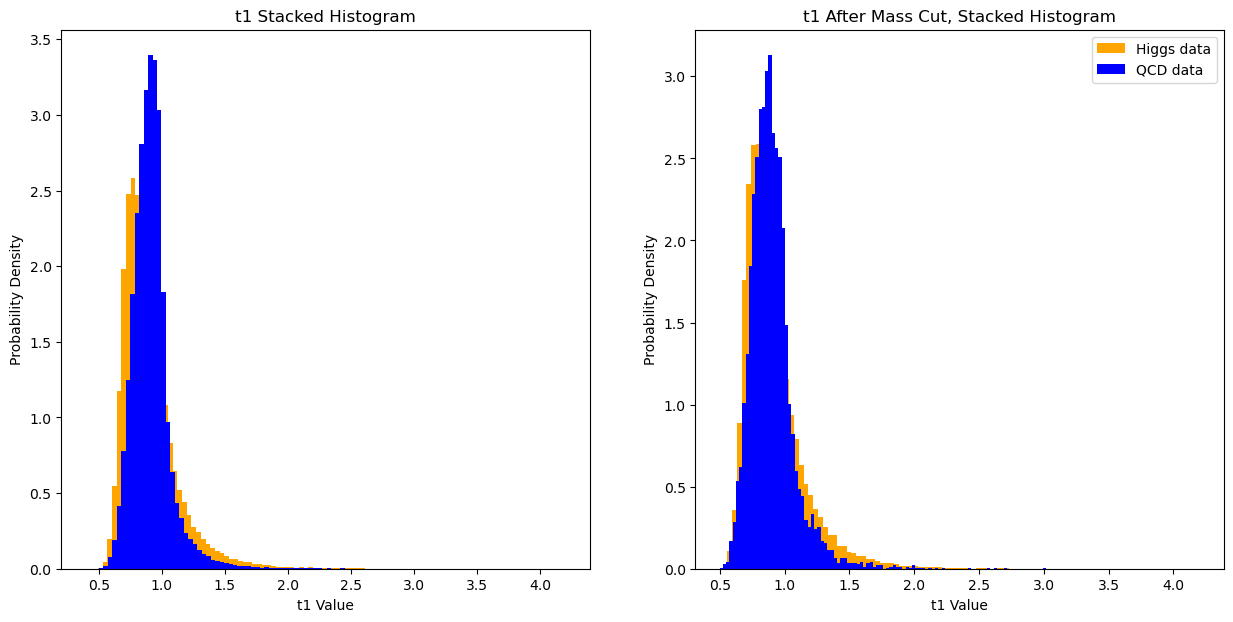

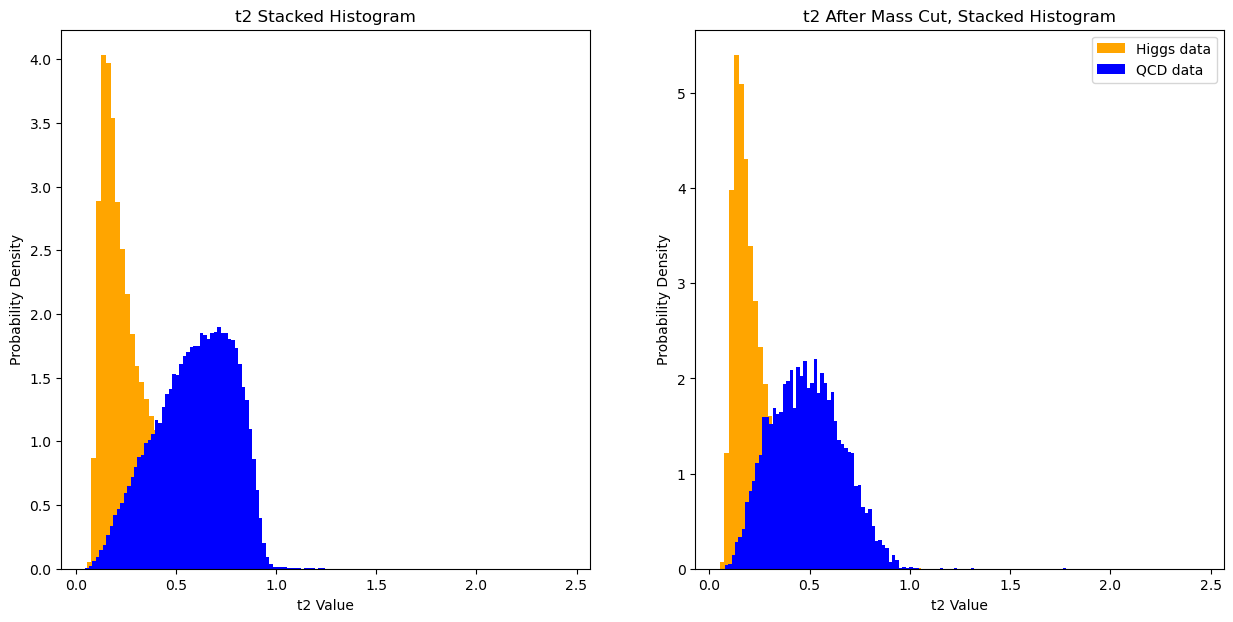

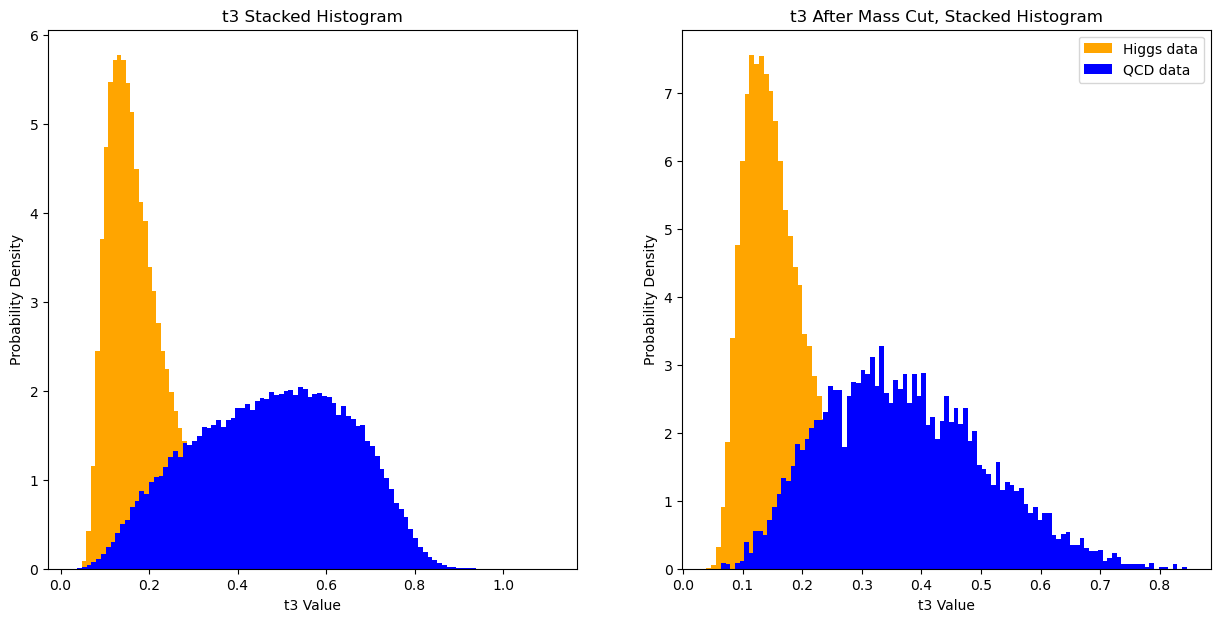

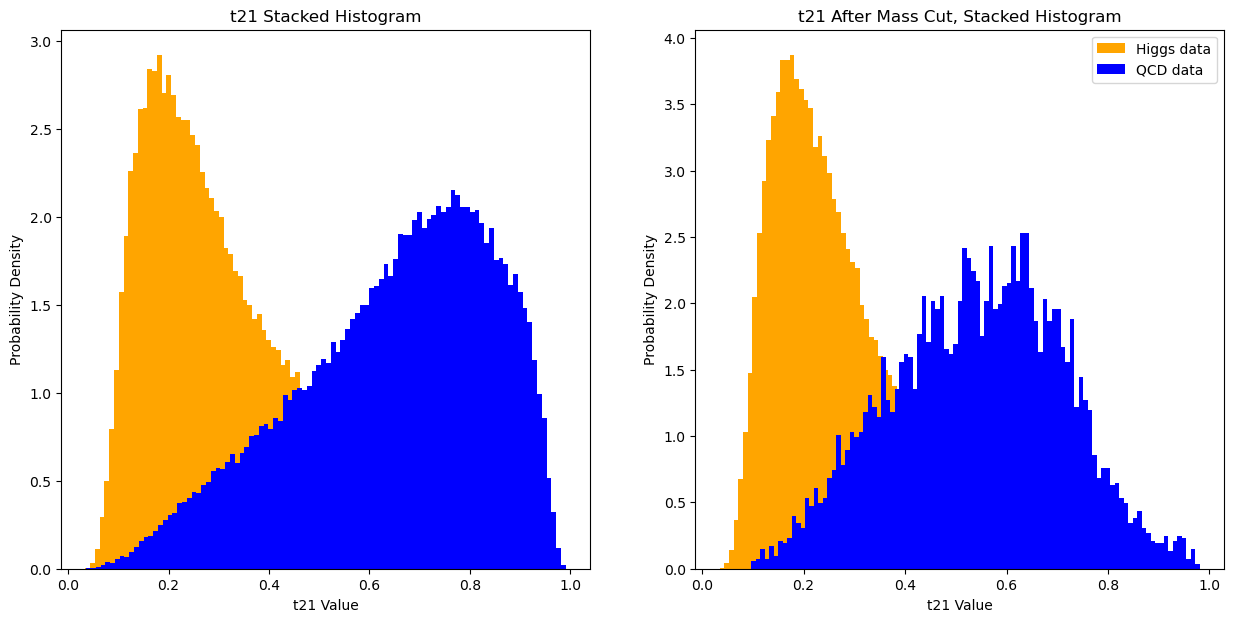

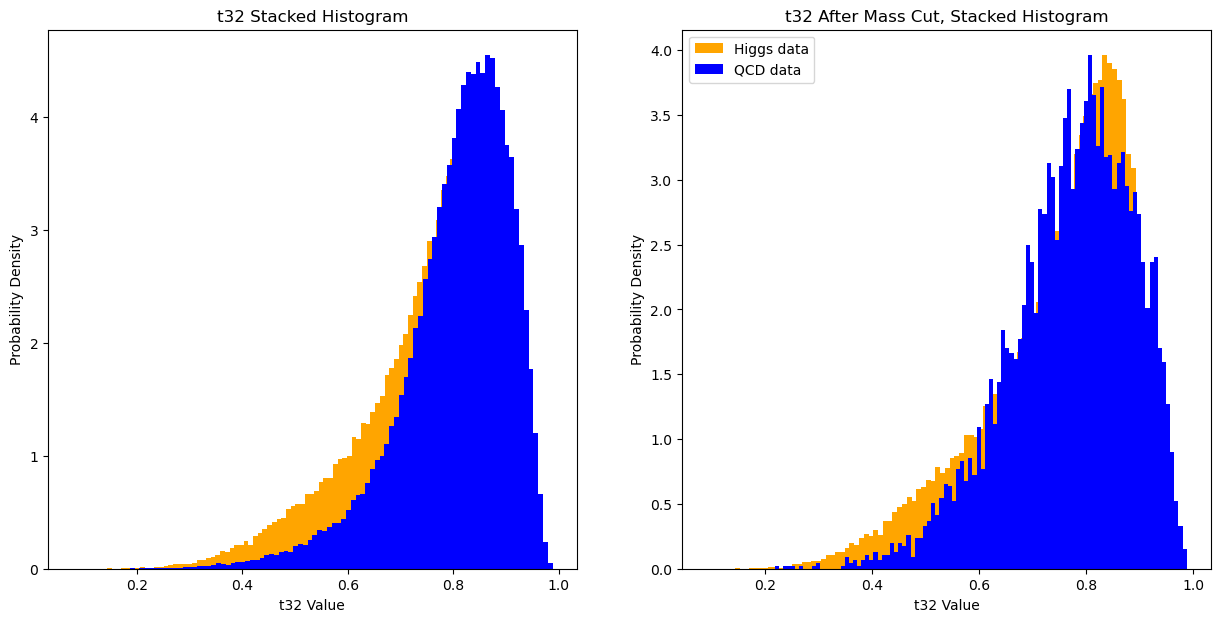

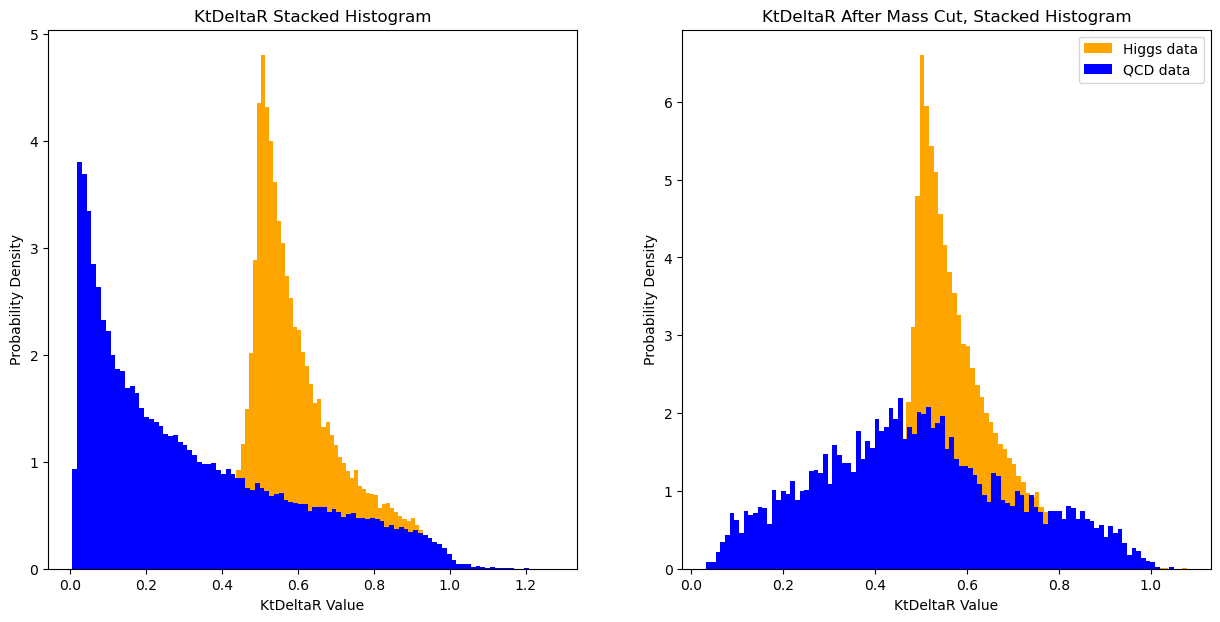

In [18]:
plt.rcParams["figure.figsize"] = (15, 7)
for key in higgs_data.keys():
    higgs_vals = higgs_data[key][mass_cut_higgs_indices]
    qcd_vals = qcd_data[key][mass_cut_qcd_indices]
    #Two stacks
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.hist(higgs_data[key], 100, density=True, color='orange', label='Higgs data')
    ax1.hist(qcd_data[key], 100, density=True, color='b', label='QCD data')
    ax2.hist(higgs_vals, 100, density=True, color='orange', label='Higgs data')
    ax2.hist(qcd_vals, 100, density=True, color='b', label='QCD data')
    
    ax1.set_xlabel(str(key) + ' Value')
    ax2.set_xlabel(str(key) + ' Value')
    ax1.set_ylabel('Probability Density')
    ax2.set_ylabel('Probability Density')
    ax1.set_title(str(key)+ ' Stacked Histogram')
    ax2.set_title(str(key) + ' After Mass Cut, Stacked Histogram')
   
    plt.legend()
    plt.show()

<h3>Problem 4</h3>

Optimize event selections using multiple features from the dataset, and find a set of feature cuts <br>
which achieve high expected significance. Below is the list of all the features that could be used to<br>
optimize the event selections. 

In [19]:
higgs_data.keys()

Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')

The feature cuts on the t2 data looks like a potential feature to improve the significance, so the optimal feature cuts<br>
on the t2

523.6
Significance is 1.676316948048076 sigma


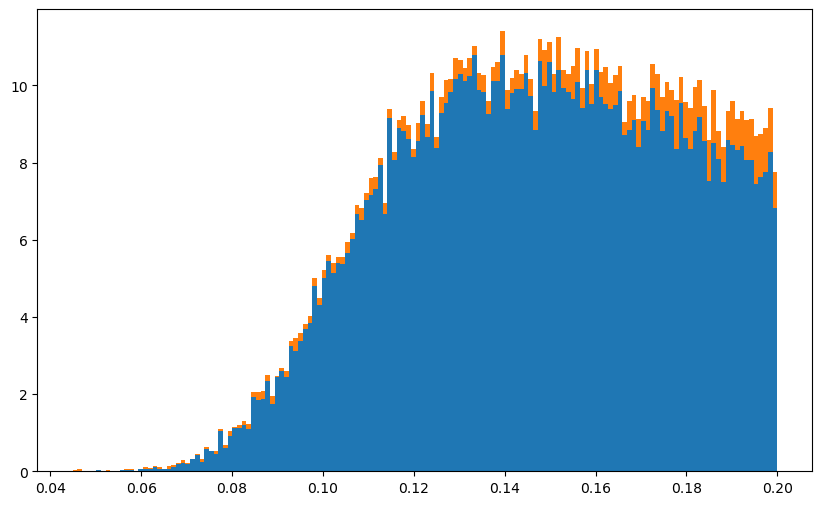

In [20]:
t2_higgs = higgs_data['t2']
t2_qcd = qcd_data['t2']

high = 0.20
cut_t2higgs = [x for x in t2_higgs if x < high]
cut_t2qcd = [x for x in t2_qcd if x < high]

n_higgs = len(cut_t2higgs)/len(t2_higgs)*100
n_qcd = len(cut_t2qcd)/len(t2_qcd)*20000
mu = n_qcd
print(mu)

stdev = stats.poisson.std(mu)
sig = n_higgs/stdev
print(f"Significance is {sig} sigma")

plt.rcParams["figure.figsize"] = (10,6)
finalplot_t2 = plt.hist([cut_t2higgs, cut_t2qcd], bins=150, 
                     stacked=True, density=True, histtype='barstacked',
                     label=['higgs', 'qcd'])

As shown on top, the significance from just the t2 cut is not big enough as the optimal ass cuts, so the cut will <br>
be applied to the filtered data from the mass cuts to seek a higher significance. 

22.8
Significance is 7.287429723413064 sigma


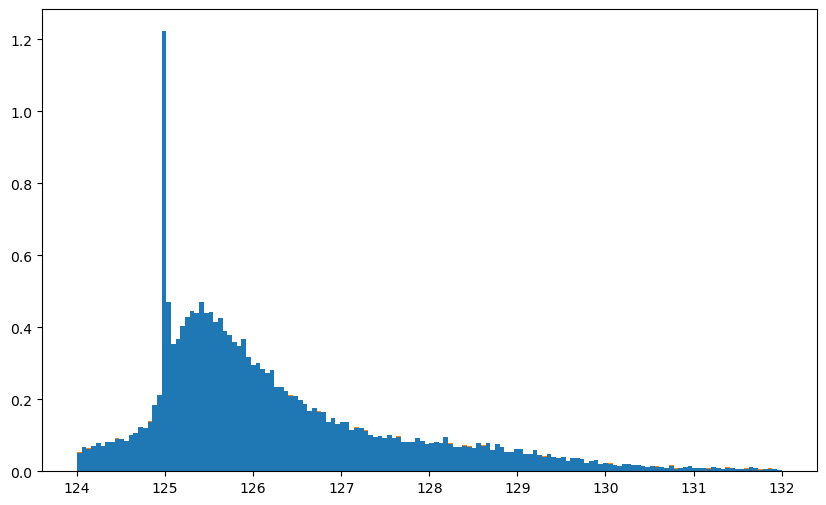

In [21]:
newHiggs = higgs_data[higgs_data['mass'].isin([x for x in higgs_data['mass'] if x > 124 and x < 132])]
mt2cut_higgs = newHiggs[newHiggs['t2'].isin(cut_t2higgs)]['mass']
newqcd = qcd_data[qcd_data['mass'].isin([x for x in qcd_data['mass'] if x > 124 and x < 132])]
mt2cut_qcd = newqcd[newqcd['t2'].isin(cut_t2qcd)]['mass']

finalplot_mass = plt.hist([mt2cut_higgs, mt2cut_qcd], bins=150, 
                     stacked=True, density=True, histtype='barstacked',
                     label=['higgs', 'qcd'])

n_higgs = len(mt2cut_higgs)/len(higgs_data['mass'])*100
n_qcd = len(mt2cut_qcd)/len(qcd_data['mass'])*20000
mu = n_qcd
print(mu)

stdev = stats.poisson.std(mu)
sig = n_higgs/stdev
print(f"Significance is {sig} sigma")

Now the significance is 7.28, which is significantly higher than before when it was just cut with t2. 

<h2>Lab 8 - Pseudo-Experiment Data Analysis</h2>

<h3>Problem 1 - High luminosity data</h3>

For each feature of your event selection, plot the observed data overlapped with expected signal and <br>
background with/without event selection.

In [57]:
hf = h5py.File('datafile/data_highLumi_pt_250_500.h5', 'r')

In [58]:
high_lumin = np.array(hf.get('data').get('block0_values'))
hf.close() 

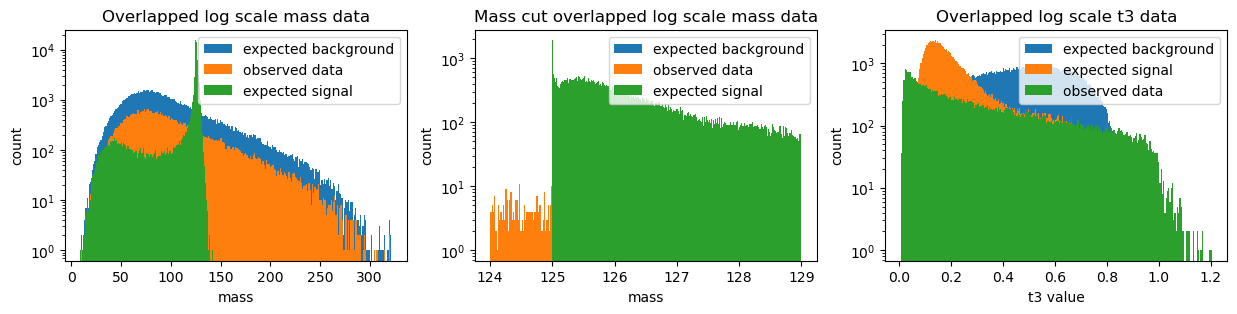

In [86]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
ax[0].hist(qcd_data['mass'], bins = 250, label= "expected background")
ax[0].hist(high_lumin[:,3], bins = 250, label = "observed data")
ax[0].hist(higgs_data['mass'], bins = 250, label= "expected signal" )
ax[0].set_yscale('log')
ax[0].set_xlabel("mass")
ax[0].set_ylabel("count")
ax[0].set_title("Overlapped log scale mass data")
ax[0].legend()


high_lumin_cut = (high_lumin[:,3] > 124) & (high_lumin[:,3] < 129)
ax[1].hist(qcd_data['mass'][(qcd_data['mass'] > 125) & (qcd_data['mass'] < 129)], bins = 250, label= "expected background")
ax[1].hist(high_lumin[:,3][high_lumin_cut], bins = 250, label = "observed data")
ax[1].hist(higgs_data['mass'][(higgs_data['mass'] > 125) & (higgs_data['mass'] < 129)], bins = 250, label= "expected signal" )
ax[1].set_yscale('log')
ax[1].set_xlabel("mass")
ax[1].set_ylabel("count")
ax[1].set_title("Mass cut overlapped log scale mass data")
ax[1].legend()


ax[2].hist(qcd_data['t3'], bins = 250, label= "expected background")
ax[2].hist(higgs_data['t3'], bins = 250, label= "expected signal" )
ax[2].hist(high_lumin[:,13], bins = 250, label = "observed data")
ax[2].set_yscale('log')
ax[2].set_ylabel("count")
ax[2].set_xlabel("t3 value")
ax[2].set_title("Overlapped log scale t3 data")
ax[2].legend()

<h3>Problem 2 - Low luminosity data</h3>

In [87]:
hf = h5py.File('datafile/data_lowLumi_pt_250_500.h5', 'r')

In [88]:
low_lumin = np.array(hf.get('data').get('block0_values'))
hf.close()

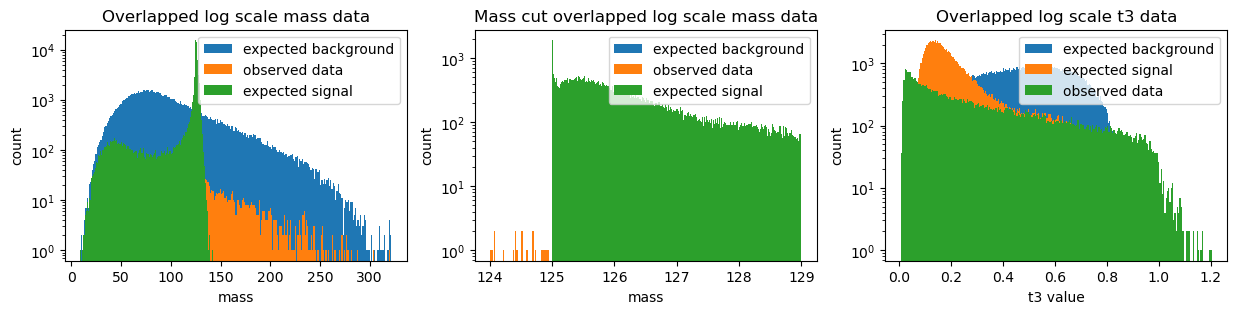

In [89]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
ax[0].hist(qcd_data['mass'], bins = 250, label= "expected background")
ax[0].hist(low_lumin[:,3], bins = 250, label = "observed data")
ax[0].hist(higgs_data['mass'], bins = 250, label= "expected signal" )
ax[0].set_yscale('log')
ax[0].set_xlabel("mass")
ax[0].set_ylabel("count")
ax[0].set_title("Overlapped log scale mass data")
ax[0].legend()


low_lumin_cut = (low_lumin[:,3] > 124) & (low_lumin[:,3] < 129)
ax[1].hist(qcd_data['mass'][(qcd_data['mass'] > 125) & (qcd_data['mass'] < 129)], bins = 250, label= "expected background")
ax[1].hist(low_lumin[:,3][low_lumin_cut], bins = 250, label = "observed data")
ax[1].hist(higgs_data['mass'][(higgs_data['mass'] > 125) & (higgs_data['mass'] < 129)], bins = 250, label= "expected signal" )
ax[1].set_yscale('log')
ax[1].set_xlabel("mass")
ax[1].set_ylabel("count")
ax[1].set_title("Mass cut overlapped log scale mass data")
ax[1].legend()


ax[2].hist(qcd_data['t3'], bins = 250, label= "expected background")
ax[2].hist(higgs_data['t3'], bins = 250, label= "expected signal" )
ax[2].hist(high_lumin[:,13], bins = 250, label = "observed data")
ax[2].set_yscale('log')
ax[2].set_ylabel("count")
ax[2].set_xlabel("t3 value")
ax[2].set_title("Overlapped log scale t3 data")
ax[2].legend()


<h3>Problem 3</h3>

In the low luminosity data, the observed significance is less than 5 σ . We will calculate the 95% confidence level <br>
upper limit of signal yield.

In [110]:
observed_confidence_interval = stats.norm.ppf(stats.poisson.cdf(0.95,12.5))
observed_confidence_interval

-4.480314698770361

The expected significance after the mass and t2 cuts is 1.67, and the low luminosity data has a significance of 4.48 after the mass and t3 cuts, <br>
which is not high enough to claim a discovery.